In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as skr
import nltk

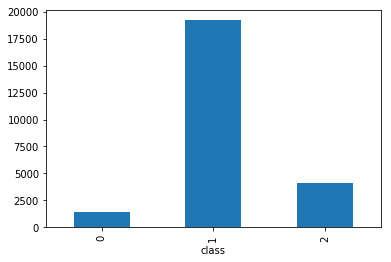

In [85]:
df_dataset = pd.read_csv('dataset.csv')
df_dataset.dropna(axis=0, inplace=True)
df_dataset.groupby("class")['id'].count().plot.bar()

Read the document containing the Train-set and save the information and drop the unnecessary colums from the saved data.

Hate speech:  1153
Offensive:  14327
Neither:  3136


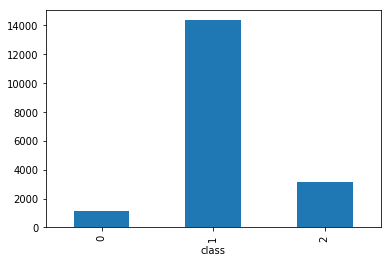

In [84]:
df_train = pd.read_csv('train.csv')
df_train.dropna(axis=0, inplace=True)
df_train.groupby("class")['id'].count().plot.bar()

print('Hate speech: ',len(df_train[df_train['class']==0]))
print('Offensive: ',len(df_train[df_train['class']==1]))
print('Neither: ',len(df_train[df_train['class']==2]))

df_train.drop(['count'], axis=1, inplace=True)
df_train.drop(['hate_speech'], axis=1, inplace=True)
df_train.drop(['offensive_language'], axis=1, inplace=True)
df_train.drop(['neither'], axis=1, inplace=True)

Read the document containing the Test-set and save the information and drop the unnecessary colums from the saved data.

Hate speech:  277
Offensive:  4863
Neither:  1027


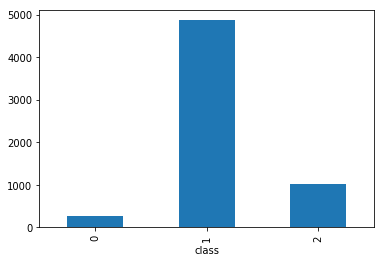

In [74]:
df_test = pd.read_csv('test.csv')
df_test.dropna(axis=0, inplace=True)
df_test.groupby("class")['id'].count().plot.bar()

print('Hate speech: ',len(df_test[df_test['class']==0]))
print('Offensive: ',len(df_test[df_test['class']==1]))
print('Neither: ',len(df_test[df_test['class']==2]))


df_test.drop(['count'], axis=1, inplace=True)
df_test.drop(['hate_speech'], axis=1, inplace=True)
df_test.drop(['offensive_language'], axis=1, inplace=True)
df_test.drop(['neither'], axis=1, inplace=True)

The method below cleans the data 

In [32]:
def clean(tweet, stem_words=True):
    import re   
    from string import punctuation
    from nltk.corpus import stopwords 
    import nltk
    from nltk.tokenize import word_tokenize

    
    punctuation = re.sub("!" , '', punctuation)
    # Empty question

    if type(tweet) != str or tweet=='':
        return ''
    
    tweet = re.sub("\'s", " ", tweet)
    tweet = re.sub(" whats ", " what is ", tweet, flags=re.IGNORECASE)
    tweet = re.sub("\'ve", " have ", tweet)
    tweet = re.sub('@[^\s]+','',tweet)
    tweet = re.sub(r'^http?:\/\/.*[\r\n]*', '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub('[' + punctuation + ']', '', tweet)
    tweet = re.sub('[0-9]', '', tweet)
    tweet = re.sub(' +', ' ', tweet)
    tweet = re.sub('RT', '', tweet)
    tweet = re.sub('bitches', 'bitch', tweet)

    return tweet

The clean method is applied to the Train-set and to theTest-set

In [33]:
df_train['tweet'] = df_train['tweet'].apply(clean)
df_test['tweet'] = df_test['tweet'].apply(clean)

In [34]:
labels = df_train['class'].values
tweet = df_train['tweet'].values

labels_test = df_test['class'].values
tweet_test = df_test['tweet'].values

The method below specify the features of the cunfiusion matrix used to visualize the results of the predictions, done by the classifiers

In [78]:
from sklearn.metrics import confusion_matrix

def show_confusion_matrix(cm):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index = ["Hate Speech", "Offensive", "Neither"],
                      columns = ["Hate speech", "Offensive", "Neither"])
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, fmt='g')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

***

# Bag of words
The tweets of the Train-set get vectorized

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize


vectorizer = CountVectorizer()
vectorizer.fit(tweet)
X = vectorizer.transform(tweet)

# Bag of words test-set
The tweets of the Test-set get vectorized

In [37]:
X_test = vectorizer.transform(tweet_test)

# MultinomialNB

In [38]:
from sklearn.naive_bayes import MultinomialNB

classifier_multi = MultinomialNB()
classifier_multi.fit(X,labels)
labels_pred_multi = classifier_multi.predict(X_test)

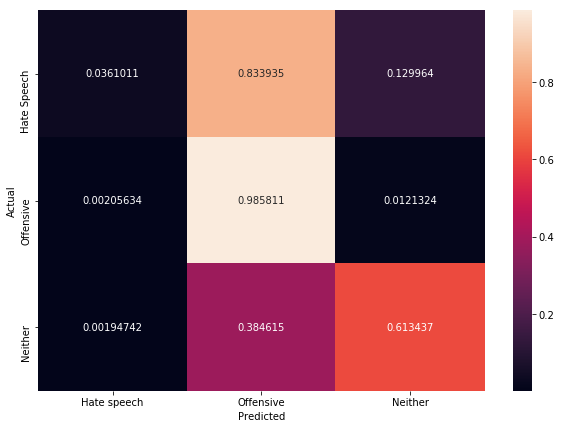

In [79]:
cm_multi = confusion_matrix(labels_test, labels_pred_multi)
show_confusion_matrix(cm_multi)

# SVM

In [64]:
from sklearn import svm

classifier_svm = svm.SVC(gamma='scale')
classifier_svm.fit(X, labels)
labels_pred_svm = classifier_svm.fit(X, labels).predict(X_test)

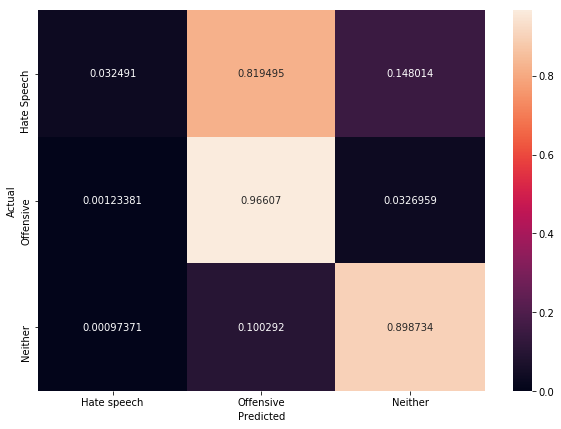

In [80]:
cm_svm = confusion_matrix(labels_test, labels_pred_svm)
show_confusion_matrix(cm_svm)

# Scores

In [66]:
print('MultinomialNB: ',classifier_multi.score(X_test, labels_test))
print('SVM score: ',classifier_svm.score(X_test, labels_test) )

MultinomialNB:  0.8811415599156802
SVM score:  0.9129236257499594


***

# Word2Vec


In [43]:
import gensim
from gensim.models import Word2Vec 
from nltk.tokenize import word_tokenize 

tweets_tr = df_train['tweet'].values
tweets_ts = df_test['tweet'].values

tok_train = []
for token in tweet:
    tok_train.append(word_tokenize(token))


tok_test = []
for token in tweet:
    tok_test.append(word_tokenize(token))

train = tok_train+tok_test
model = Word2Vec(train)
model.init_sims(replace=True)

In [44]:
def sent2vec(s, model): 
    M = []
    words = word_tokenize(str(s).lower())
    for word in words:
        if word in model:
            M.append(model[word])
    M = np.array(M)
    if len(M) > 0:
        v = M.sum(axis=0)
        return v / np.sqrt((v ** 2).sum())
    else:
        return np.zeros(100)

In [45]:
w2v = np.array([sent2vec(t, model) for t in tweets_tr])

C:\Users\Matteo\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  """
C:\Users\Matteo\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


# Word2Vec test-set

In [46]:
w2v_test = np.array([sent2vec(t, model) for t in tweets_ts])

C:\Users\Matteo\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  """
C:\Users\Matteo\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


# XGB Classifier

In [47]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
w2vX = xgb.fit(w2v, labels)
labels_pred_xgb = xgb.predict(w2v_test)

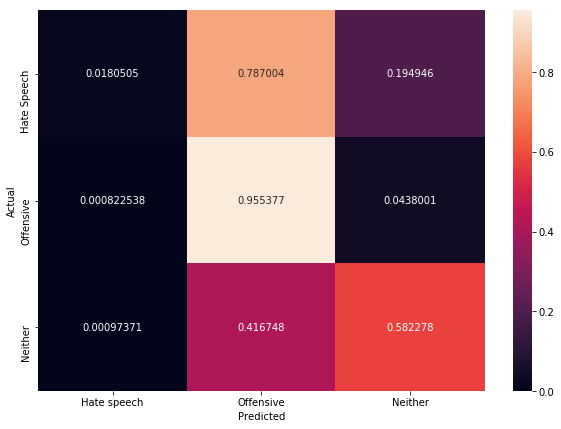

In [81]:
cm_xgb = confusion_matrix(labels_test, labels_pred_xgb)
show_confusion_matrix(cm_xgb)

# SVM

In [49]:
from sklearn import svm

classifier_svm = svm.SVC(gamma='scale')
classifier_svm.fit(w2v, labels)
labels_pred_svm2 = classifier_svm.fit(w2v, labels).predict(w2v_test)

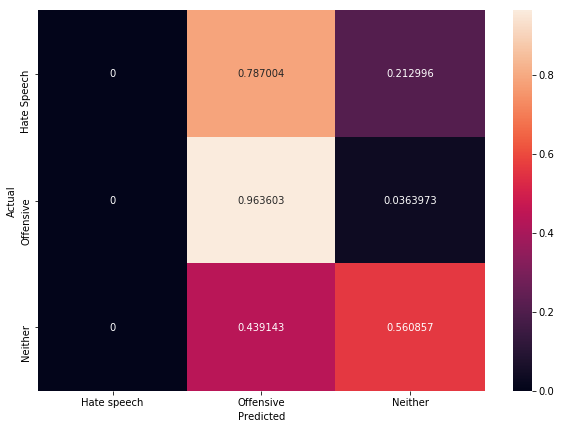

In [82]:
cm_svm2 = confusion_matrix(labels_test, labels_pred_svm2)
show_confusion_matrix(cm_svm2)

# Score

In [51]:
print( 'XGB score: ',xgb.score(w2v_test, labels_test))
print('SVM score: ' ,classifier_svm.score(w2v_test, labels_test) )

XGB score:  0.8511431814496514
SVM score:  0.853251175612129


***

# Wordcloud of the Data-set

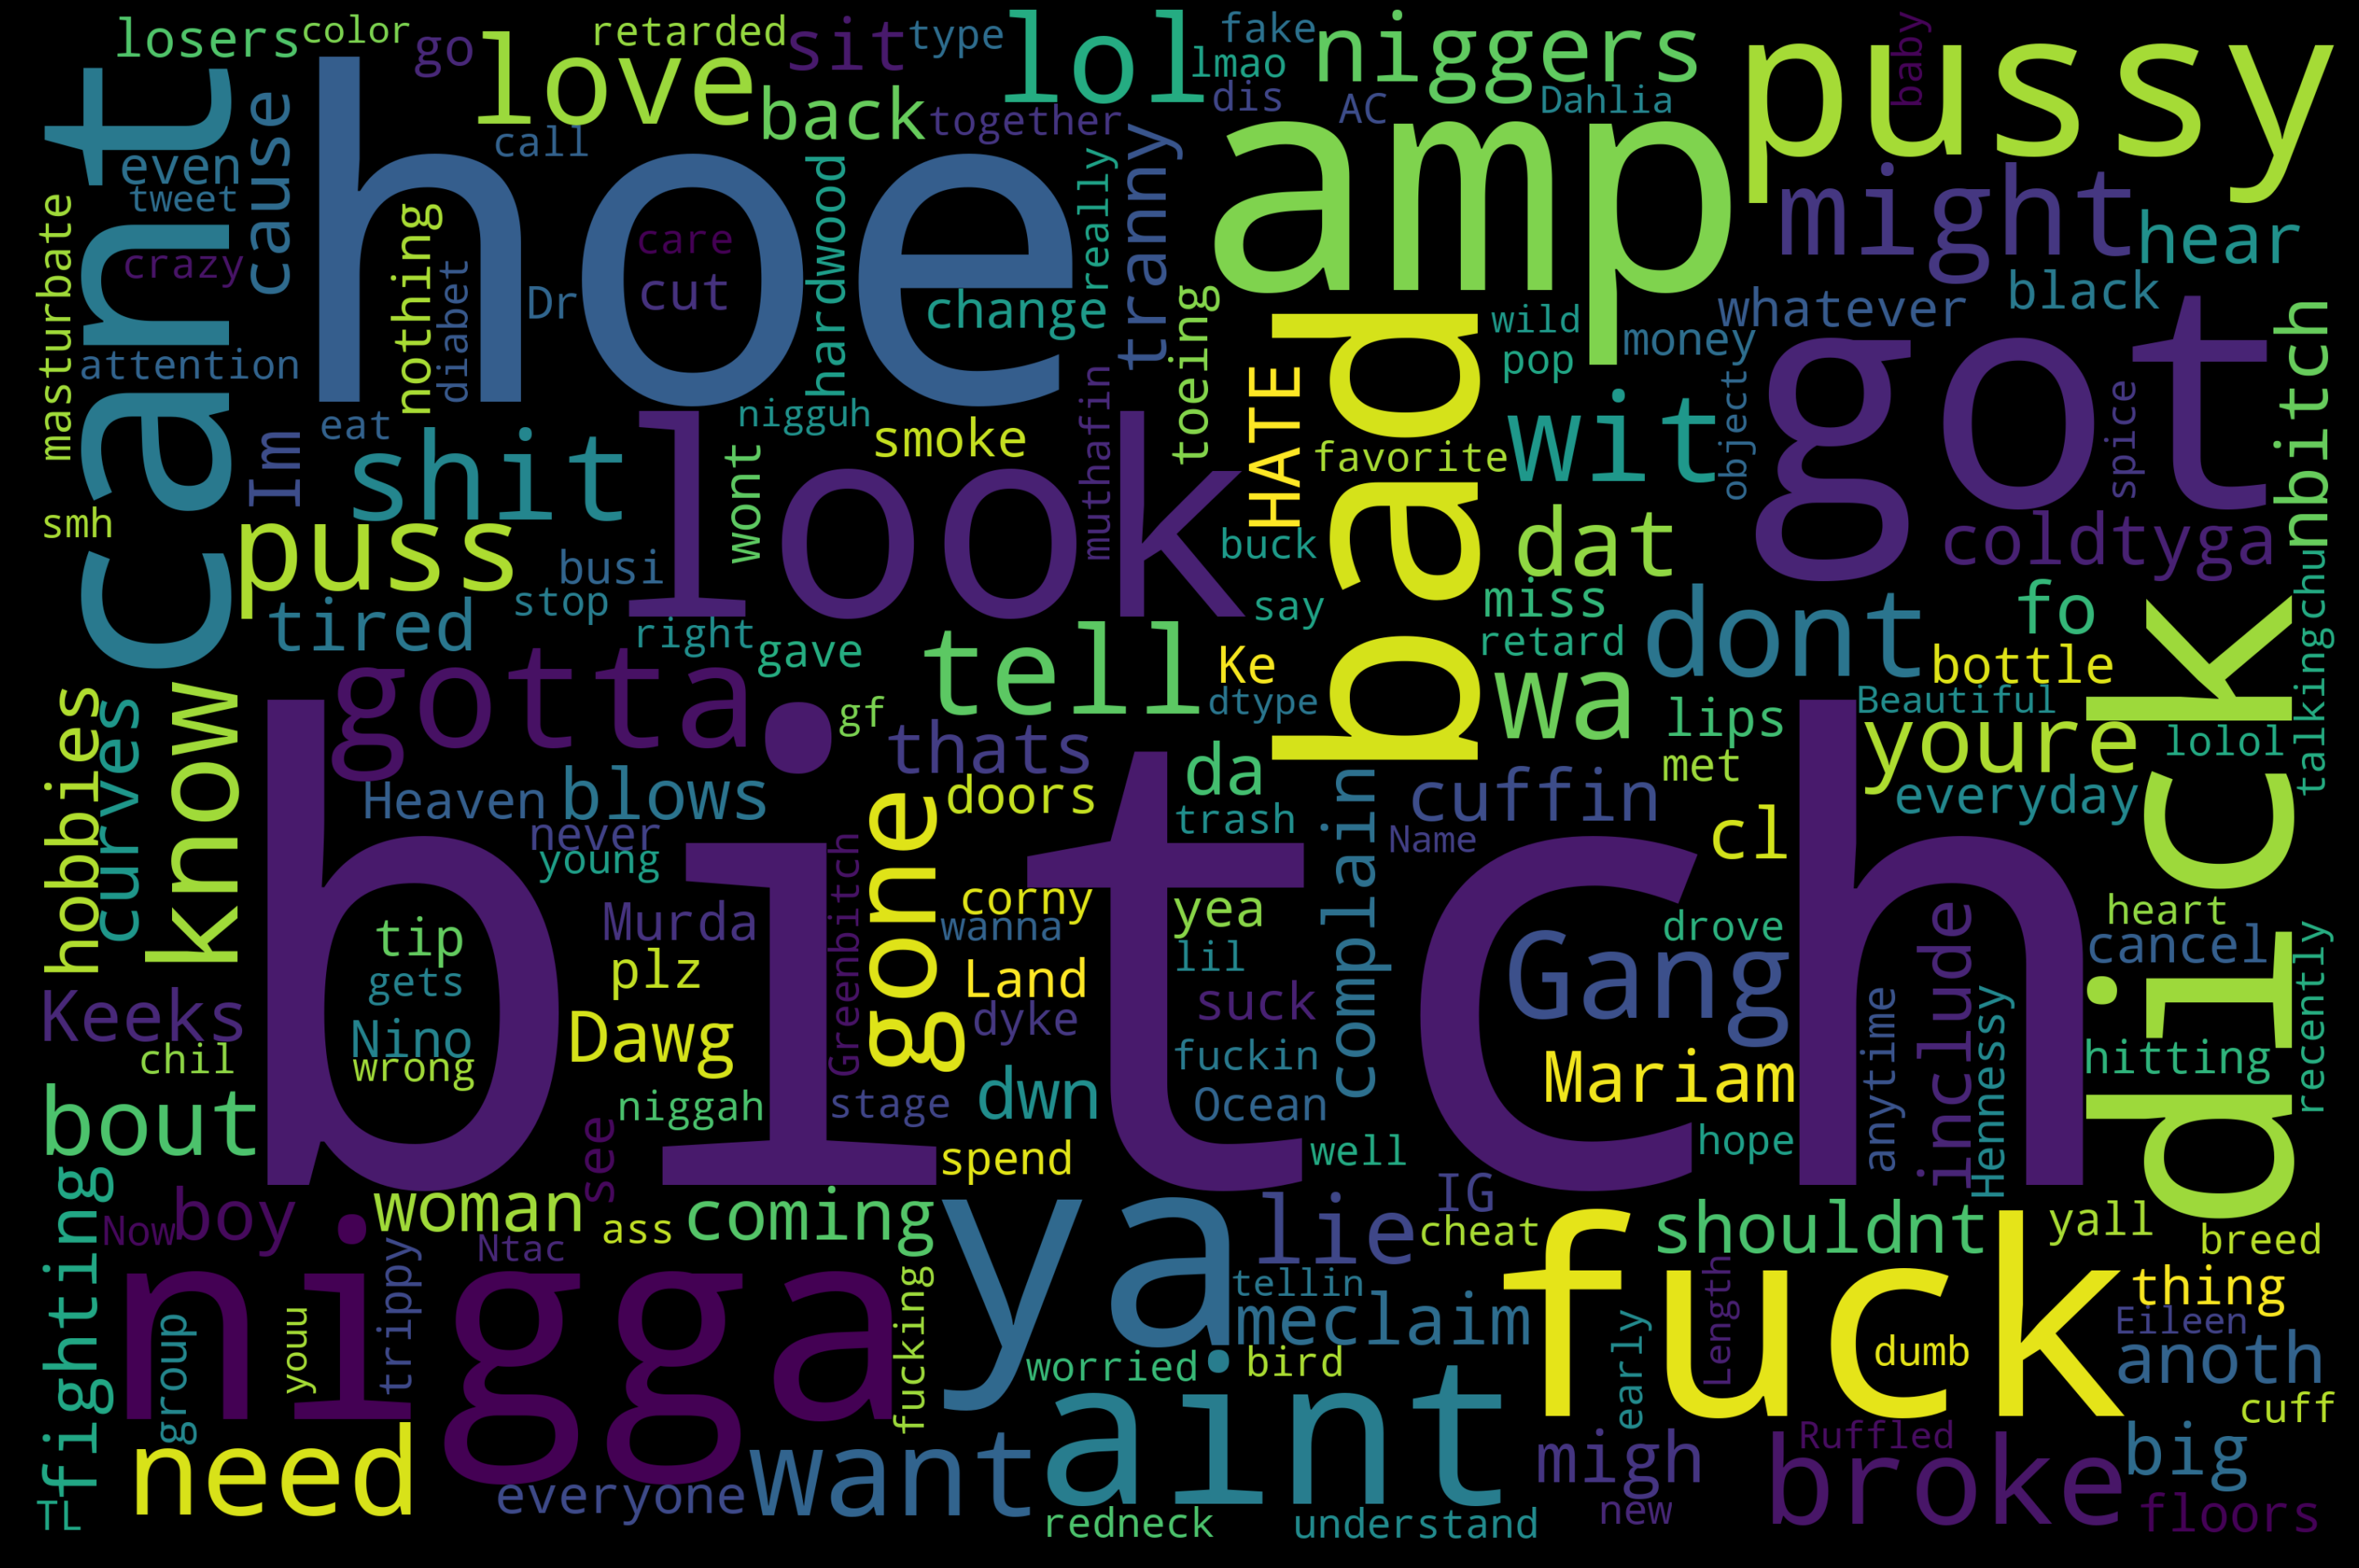

In [53]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
df_set = pd.read_csv('dataset.csv')
df_set.dropna(axis=0, inplace=True)
df_set['tweet'] = df_set['tweet'].apply(clean)
text = df_set.tweet
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()